
Audio Classifier
=========================

This is inspired by the Audio Classifier Tutorial (found [here](https://pytorch.org/tutorials/beginner/audio_classifier_tutorial.html?highlight=audio))
**Author**: `Winston Herring <https://github.com/winston6>`_

This tutorial will show you how to correctly format an audio dataset and
then train/test an audio classifier network on the dataset. First, let’s
import the common torch packages as well as ``torch``, ``torchaudio``, ``pandas``,
and ``numpy``. ``torchaudio`` is available `here <https://github.com/pytorch/audio>`_
and can be installed by following the
instructions on the website but I encountered a lot of trouble installing it, this ` conda install -c pytorch torchaudio-cpu ` rather worked for me.




If you have a CUDA GPU use that. Running
the network on a GPU will greatly decrease the training/testing runtime.




1: Importing the Dataset
---------------------

We will use the UrbanSound8K dataset to train our network. It is
available for free `here <https://urbansounddataset.weebly.com/>`_ and contains
10 audio classes with over 8000 audio samples! Once you have downloaded
the compressed dataset, extract it to your current working directory.
First, we will look at the csv file that provides information about the
individual sound files. ``pandas`` allows us to open the csv file and
use ``.iloc()`` to access the data within it.




The 10 audio classes in the UrbanSound8K dataset are air_conditioner,
car_horn, children_playing, dog_bark, drilling, enginge_idling,
gun_shot, jackhammer, siren, and street_music. Let’s play a couple files
and see what they sound like. The first file is street music and the
second is an air conditioner.




2: Formatting the Data
-------------------

Now that we know the format of the csv file entries, we can construct
our dataset. We will create a rapper class for our dataset using
``torch.utils.data.Dataset`` that will handle loading the files and
performing some formatting steps. The UrbanSound8K dataset is separated
into 10 folders. We will use the data from 9 of these folders to train
our network and then use the 10th folder to test the network. The rapper
class will store the file names, labels, and folder numbers of the audio
files in the inputted folder list when initialized. The actual loading
and formatting steps will happen in the access function ``__getitem__``.

In ``__getitem__``, we use ``torchaudio.load()`` to convert the wav
files to tensors. ``torchaudio.load()`` returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(44.1kHz for UrbanSound8K). The dataset uses two channels for audio so
we will use ``torchaudio.transforms.DownmixMono()`` (not available in the latest version of `torchaudio`) to convert the audio
data to one channel. Next, we need to format the audio data. The network
we will make takes an input size of 32,000, while most of the audio
files have well over 100,000 samples. The UrbanSound8K audio is sampled
at 44.1kHz, so 32,000 samples only covers around 700 milliseconds. By
downsampling the audio to aproximately 8kHz, we can represent 4 seconds
with the 32,000 samples. This downsampling is achieved by taking every
fifth sample of the original audio tensor. Not every audio tensor is
long enough to handle the downsampling so these tensors will need to be
padded with zeros. The minimum length that won’t require padding is
160,000 samples.




3: Define the Network
------------------

For this task we want to closely reproduce the achitectures described in https://arxiv.org/pdf/1610.00087.pdf. You task is to read extensively the paper and reproduce the achitectures M3, M5, M11 and M18. The M34-res is a bonus.
While attempting to reproduce the architectures endeavour to read through the common [pitfalls](https://urbansounddataset.weebly.com/urbansound8k.html#10foldCV) to get it right.

We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training.




4: Training and Testing the Network
--------------------------------

You can define a training function that will feed our training data into the model and perform the backward pass and optimization steps. You can also make one for testing the networks accuracy and set the model to ``eval()`` mode and then run inference on the test dataset. Calling ``eval()`` sets the training variable in all modules in the network to false. Certain layers like batch normalization and dropout layers behave differently during training so this step is crucial for getting correct results.




Finally, we can train and test the network. Train the network for as many epochs as time allows you. The network will be tested after each epoch to see how the accuracy varies during the training.

Conclusion
----------

If trained on 9 folders, the network should be about 40% accurate by the end of the training process for the least possible epochs. Training on less folders will result in a lower overall accuracy. Greater accuracies can be achieved using deeper CNNs at the expense of a larger memory footprint.

For more advanced audio applications, such as speech recognition,
recurrent neural networks (RNNs) are commonly used. There are also other
data preprocessing methods, such as finding the mel frequency cepstral
coefficients (MFCC), that can reduce the size of the dataset.




<font color='red'>GOOD NEWS</font> : Solutions to the first two section have been given to you freely. 

In [4]:
import os
import glob
import numpy as np
import pandas as pd
from IPython.display import Audio
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchaudio
from torchvision import models
import skorch
import matplotlib.pyplot as plt
#from torchaudio.transforms import DownmixMono
#
import tarfile
from sklearn.model_selection import KFold

In [5]:
aud, rate = torchaudio.load('UrbanSound8K/audio/fold1/7061-6-0-0.wav')

In [6]:
Audio(aud, rate=rate)

In [7]:
AA = aud.mean(0, keepdim=True)#.shape

In [ ]:
Audio(AA, rate=rate)

In [8]:
def gen_toeplitz(N, alpha): # 5 pts
    # Write your code here
    x = y = torch.arange(1, N+1)
    I, J = torch.meshgrid(x,y)
    T = torch.sqrt(torch.Tensor([alpha/np.pi])) * (-alpha * (I-J).pow_(2)).exp_()
    return T

def convolution(signal, N, alpha):
    
    Toeplitz_matrix = gen_toeplitz(N, alpha)
    convolved_signal = signal @ Toeplitz_matrix
    return convolved_signal

In [9]:
c, n = AA.shape
zero_need = 160000 - n
audio_new = F.pad(AA, (zero_need //2, zero_need //2), 'constant', 0)
audio_new = audio_new[:,::5]

In [27]:
gen_toeplitz(n, 0.5)

tensor([[0.3989, 0.2420, 0.0540,  ..., 0.0000, 0.0000, 0.0000],
        [0.2420, 0.3989, 0.2420,  ..., 0.0000, 0.0000, 0.0000],
        [0.0540, 0.2420, 0.3989,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.3989, 0.2420, 0.0540],
        [0.0000, 0.0000, 0.0000,  ..., 0.2420, 0.3989, 0.2420],
        [0.0000, 0.0000, 0.0000,  ..., 0.0540, 0.2420, 0.3989]])

In [11]:
convolved = convolution(audio_new, audio_new.shape[1], 1/2)

In [12]:
convolved.shape

torch.Size([1, 32000])

Text(0.5, 1.0, 'Plot for $\\alpha = \\frac{1}{2}$')

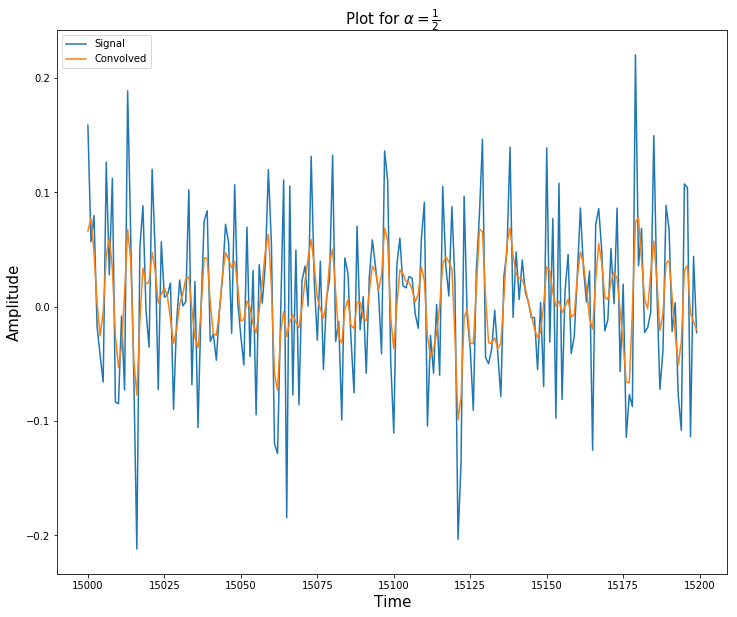

In [26]:
plt.figure(figsize=(12,10))

plt.plot(np.arange(15000, 15200),audio_new[0,15000:15200], label = 'Signal')
plt.plot(np.arange(15000, 15200),convolved[0,15000:15200], label= 'Convolved')
plt.legend()
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time", fontsize=15)
plt.title('Plot for $\\alpha = \\frac{1}{2}$', fontsize=15)

In [31]:
class AudioDataset(Dataset):

    def __init__(self, file_path, audio_paths, folds):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        self.audio_file = pd.read_csv(file_path)
        self.folds = folds
        self.audio_paths = glob.glob(audio_paths + '/*' + str(self.folds) + '/*')
    
    

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        
        audio_path = self.audio_paths[idx]
        audio, rate = torchaudio.load(audio_path, normalization=True)
        audio = audio.mean(0, keepdim=True)
        c, n = audio.shape
        zero_need = 160000 - n
        audio_new = F.pad(audio, (zero_need //2, zero_need //2), 'constant', 0)
        audio_new = audio_new[:,::5]
        audio_conv = convolution(audio_new, audio_new.shape[1], 1/2)
        
        #Getting the corresponding label
        audio_name = audio_path.split(sep='/')[-1]
        labels = self.audio_file.loc[self.audio_file.slice_file_name == audio_name].iloc[0,-2]
        
        return audio_conv, labels

In [32]:
file_path = 'UrbanSound8K/metadata/UrbanSound8K.csv'
audio_paths = 'UrbanSound8K/audio'

In [33]:
train_set = AudioDataset(file_path, audio_paths, list(range(1,10)))
test_set = AudioDataset(file_path, audio_paths, 10)

In [34]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32)

In [47]:
len(train_loader)

62

In [6]:
class model_M3(nn.Module):
    def __init__(self):
        super(model_M3, self).__init__()
        self.layer1 = nn.Sequential(
                                    nn.Conv1d(in_channels=1, out_channels=256, kernel_size=80, stride=4, padding=78),
                                    nn.BatchNorm1d(256),
                                    nn.MaxPool1d(kernel_size=4),
                                    nn.ReLU()
                                )
        self.layer2 = nn.Sequential(
                                    nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                    nn.BatchNorm1d(256),
                                    nn.MaxPool1d(kernel_size=4),
                                    nn.ReLU()
                                )
        
        self.Globalpool = nn.AdaptiveAvgPool1d(1)
        self.linear = nn.Linear(256*1, 10)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.Globalpool(x)
        x = x.view(-1, 256*1)
        x = self.linear(x)
        x = F.log_softmax(x, dim=1)
        return x
        
        

In [7]:
class model_M5(nn.Module):
    def __init__(self):
        super(model_M5, self).__init__()
        self.layer1 = nn.Sequential(
                                    nn.Conv1d(in_channels=1, out_channels=128, kernel_size=80, stride=4, padding=78),
                                    nn.BatchNorm1d(128),
                                    nn.MaxPool1d(kernel_size=4),
                                    nn.ReLU()
                                )
        self.layer2 = nn.Sequential(
                                    nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                    nn.BatchNorm1d(128),
                                    nn.MaxPool1d(kernel_size=4),
                                    nn.ReLU()
                                )
        self.layer3 = nn.Sequential(
                                    nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
                                    nn.BatchNorm1d(256),
                                    nn.MaxPool1d(kernel_size=4),
                                    nn.ReLU()
                                )
        self.layer4 = nn.Sequential(
                                    nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
                                    nn.BatchNorm1d(512),
                                    nn.MaxPool1d(kernel_size=4),
                                    nn.ReLU()
                                )
        self.Globalpool = nn.AdaptiveAvgPool1d(1)
        self.linear = nn.Linear(512*1, 10)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.Globalpool(x)
        x = x.view(-1, 512*1)
        x = self.linear(x)
        x = F.log_softmax(x, dim=1)
        return x
        

In [13]:
class model_M11(nn.Module):
    def __init__(self):
        super(model_M11, self).__init__()
        self.layer1 = nn.Sequential(
                                    nn.Conv1d(in_channels=1, out_channels=64, kernel_size=80, stride=4, padding=78),
                                    nn.BatchNorm1d(64),
                                    nn.MaxPool1d(kernel_size=4),
                                    nn.ReLU()
                                )
        self.layer2 = nn.Sequential(
                                    nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                    nn.BatchNorm1d(64),
                                    nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                    nn.BatchNorm1d(64),
                                    nn.MaxPool1d(kernel_size=4),
                                    nn.ReLU()
                                    )
        
        self.layer3 = nn.Sequential(
                                    nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                                    nn.BatchNorm1d(128),
                                    nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                    nn.BatchNorm1d(128),
                                    nn.MaxPool1d(kernel_size=4),
                                    nn.ReLU()
                                    )
        self.layer4 = nn.Sequential(
                                    nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
                                    nn.BatchNorm1d(256),
                                    nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                    nn.BatchNorm1d(256),
                                    nn.MaxPool1d(kernel_size=4),
                                    nn.ReLU()
                                    )
        self.layer5 = nn.Sequential(
                                    nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
                                    nn.BatchNorm1d(512),
                                    nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                    nn.BatchNorm1d(512),
                                    nn.MaxPool1d(kernel_size=4),
                                    nn.ReLU()
                                    )
        self.Globalpool = nn.AdaptiveAvgPool1d(1)
        self.linear = nn.Linear(512*1, 10)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.Globalpool(x)
        x = x.view(-1, 512*1)
        x = self.linear(x)
        x = F.log_softmax(x, dim=1)
        return x
        

In [14]:
class model_M18(nn.Module):
    def __init__(self):
        super(model_M18, self).__init__()

        self.layer1 = nn.Sequential(
                                    nn.Conv1d(in_channels=1, out_channels=64, kernel_size=80, stride=4, padding=78),
                                    nn.BatchNorm1d(64),
                                    nn.MaxPool1d(kernel_size=4),
                                    nn.ReLU()
                                )
        self.layer2 = nn.Sequential(
                                    nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                    nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                    nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                    nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                    nn.MaxPool1d(kernel_size=4),
                                    nn.BatchNorm1d(64),
                                    nn.ReLU()
                                    )
        
        self.layer3 = nn.Sequential(
                                    nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                                    nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                    nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                    nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                    nn.MaxPool1d(kernel_size=4),
                                    nn.BatchNorm1d(128),
                                    nn.ReLU()
                                    )
        self.layer4 = nn.Sequential(
                                    nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
                                    nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                    nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                    nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                    nn.MaxPool1d(kernel_size=4),
                                    nn.BatchNorm1d(256),
                                    nn.ReLU()
                                    )
        self.layer5 = nn.Sequential(
                                    nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
                                    nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                    nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                    nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                    nn.MaxPool1d(kernel_size=4),
                                    nn.BatchNorm1d(512),
                                    nn.ReLU()
                                    )
        self.Globalpool = nn.AdaptiveAvgPool1d(1)
        self.linear = nn.Linear(512*1, 10)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.Globalpool(x)
        x = x.view(-1, 512*1)
        x = self.linear(x)
        x = F.log_softmax(x, dim=1)
        return x
        

In [ ]:
class Res_Block(nn.Module):
    def __init__(self, in_channel, out_channel, stride=1, Downsample=None):
        super(Res_Block, self).__init__()
        self.Downsample = Downsample
        self.block = nn.Sequential(nn.Conv1d(in_channel, out_channel, 3, stride, 1),
                                   nn.BatchNorm1d(out_channel),
                                   nn.ReLU(),
                                   nn.Conv1d(out_channel, out_channel, 3, stride, 1),
                                   nn.BatchNorm1d(out_channel)
                                    )
        self.batchnorm = nn.BatchNorm1d(out_channel)
        self.activate = nn.ReLU()
    def forward(self, x):
        residual = x
        x = self.block(x)
        print(x.shape, residual.shape)
        if self.Downsample:
            residual = self.Downsample(x)
        print(x.shape, residual.shape)
        print('--'*10)
        x += residual
        x = self.batchnorm(x)
        x = self.activate(x)
        return x


class model_M34res(nn.Module):
    def __init__(self, block, layers):
        super(model_M34res, self).__init__()
        
        self.in_channels = 48
        self.layer1 = nn.Sequential(
                                    nn.Conv1d(in_channels=1, out_channels=48, kernel_size=80, stride=4, padding=78),
                                    nn.BatchNorm1d(48),
                                    nn.MaxPool1d(kernel_size=4),
                                    nn.ReLU()
                                )
        self.layer2 = self.make_layer(block, 48, layers[0])
        self.layer3 = self.make_layer(block, 96, layers[1])
        self.layer4 = self.make_layer(block, 192, layers[2])
        self.layer5 = self.make_layer(block, 384, layers[3])
        self.Globalpool = nn.AdaptiveAvgPool1d(1)
        self.linear = nn.Linear(384*1, 10)
        
    def make_layer(self, block, out_channels, blocks, stride=4):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                                        nn.Conv1d(self.in_channels, out_channels, 1, stride=1),
                                        nn.BatchNorm1d(out_channels)
                                        )
        layers = []
        layers.append(block(out_channels, out_channels, 1, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            print(out_channels)
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.Globalpool(x)
        x = x.view(-1, 384*1)
        x = self.linear(x)
        x = F.log_softmax(x, dim=1)
        return x

In [ ]:
model1 = model_M3()
model2 = model_M5()
model3 = model_M11()
model4 = model_M18()
model5 = model_M34res(Res_Block, [3, 4, 6, 3])

optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01, weight_decay=0.0001)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01, weight_decay=0.0001)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.01, weight_decay=0.0001)
optimizer4 = torch.optim.Adam(model4.parameters(), lr=0.01, weight_decay=0.0001)
optimizer5 = torch.optim.Adam(model5.parameters(), lr=0.01, weight_decay=0.0001)
scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer1, patience=2, factor=0.5, mode='min', min_lr=0.001)
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2, patience=2, factor=0.5, mode='min', min_lr=0.001)
scheduler3 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer3, patience=2, factor=0.5, mode='min', min_lr=0.001)
scheduler4 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer4, patience=2, factor=0.5, mode='min', min_lr=0.001)
scheduler5 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer5, patience=2, factor=0.5, mode='min', min_lr=0.001)
criterion = nn.CrossEntropyLoss()

In [17]:
criterion = nn.NLLLoss()
models = [model_M3(), model_M5(), model_M11(), model_M18()]
split = 10
epochs = 20

In [ ]:
mod_fold_epoch_train_loss = np.zeros((len(models), split, epochs))
mod_fold_epoch_test_loss = np.zeros((len(models), split, epochs))
mod_fold_epoch_train_acc = np.zeros((len(models), split, epochs))
mod_fold_epoch_test_acc = np.zeros((len(models), split, epochs))

In [18]:
for mod in range(2, len(models)):
    print('Model', mod+1, 'training begins')
    fold = KFold(n_splits=split).split(range(1,11))
    for train, test in fold:
        print('cross-validation', test.item()+1)
        folds_train = train + 1
        folds_test = test + 1
        train_set = AudioDataset(file_path, audio_paths, folds_train)
        test_set = AudioDataset(file_path, audio_paths, folds_test)
        train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
        test_loader = DataLoader(test_set, batch_size=32)
        
        model = models[mod]
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5, mode='min', min_lr=0.001)
        
        for epoch in range(epochs):
            print('epoch', epoch+1, 'starts')
            model.train()
            train_loss = 0
            train_acc = 0
            for X, y in train_loader:
                output = model(X)
                loss = criterion(output, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                pred_train = output.data.max(1, keepdim=True)[1]                                                                 
                train_acc += pred_train.eq(y.data.view_as(pred_train)).sum().item()
            mod_fold_epoch_train_loss[mod, test.item(), epoch] = train_loss / len(train_loader)
            mod_fold_epoch_train_acc[mod, test.item(), epoch] = 100. * train_acc / len(train_loader)
            scheduler.step(train_loss)
            model.eval()
            test_loss = 0
            test_acc = 0
            for data, target in test_loader:
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
                pred_test = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
                test_acc += pred_test.eq(target.data.view_as(pred_test)).sum().item()
            mod_fold_epoch_test_loss[mod, test.item(), epoch] = test_loss / len(test_loader)
            mod_fold_epoch_test_acc[mod, test.item(), epoch] = 100. * test_acc / len(test_loader)

Model 3 training begins
cross-validation 1
epoch 1 starts
epoch 2 starts
epoch 3 starts
epoch 4 starts
epoch 5 starts
epoch 6 starts
epoch 7 starts
epoch 8 starts
epoch 9 starts
epoch 10 starts
epoch 11 starts
epoch 12 starts
epoch 13 starts
epoch 14 starts
epoch 15 starts
epoch 16 starts
epoch 17 starts
epoch 18 starts
epoch 19 starts
epoch 20 starts
cross-validation 2
epoch 1 starts
epoch 2 starts
epoch 3 starts
epoch 4 starts
epoch 5 starts
epoch 6 starts
epoch 7 starts
epoch 8 starts
epoch 9 starts
epoch 10 starts
epoch 11 starts
epoch 12 starts
epoch 13 starts
epoch 14 starts
epoch 15 starts
epoch 16 starts
epoch 17 starts
epoch 18 starts
epoch 19 starts
epoch 20 starts
cross-validation 3
epoch 1 starts
epoch 2 starts
epoch 3 starts
epoch 4 starts
epoch 5 starts
epoch 6 starts
epoch 7 starts
epoch 8 starts
epoch 9 starts
epoch 10 starts
epoch 11 starts
epoch 12 starts
epoch 13 starts
epoch 14 starts
epoch 15 starts
epoch 16 starts
epoch 17 starts
epoch 18 starts
epoch 19 starts
ep

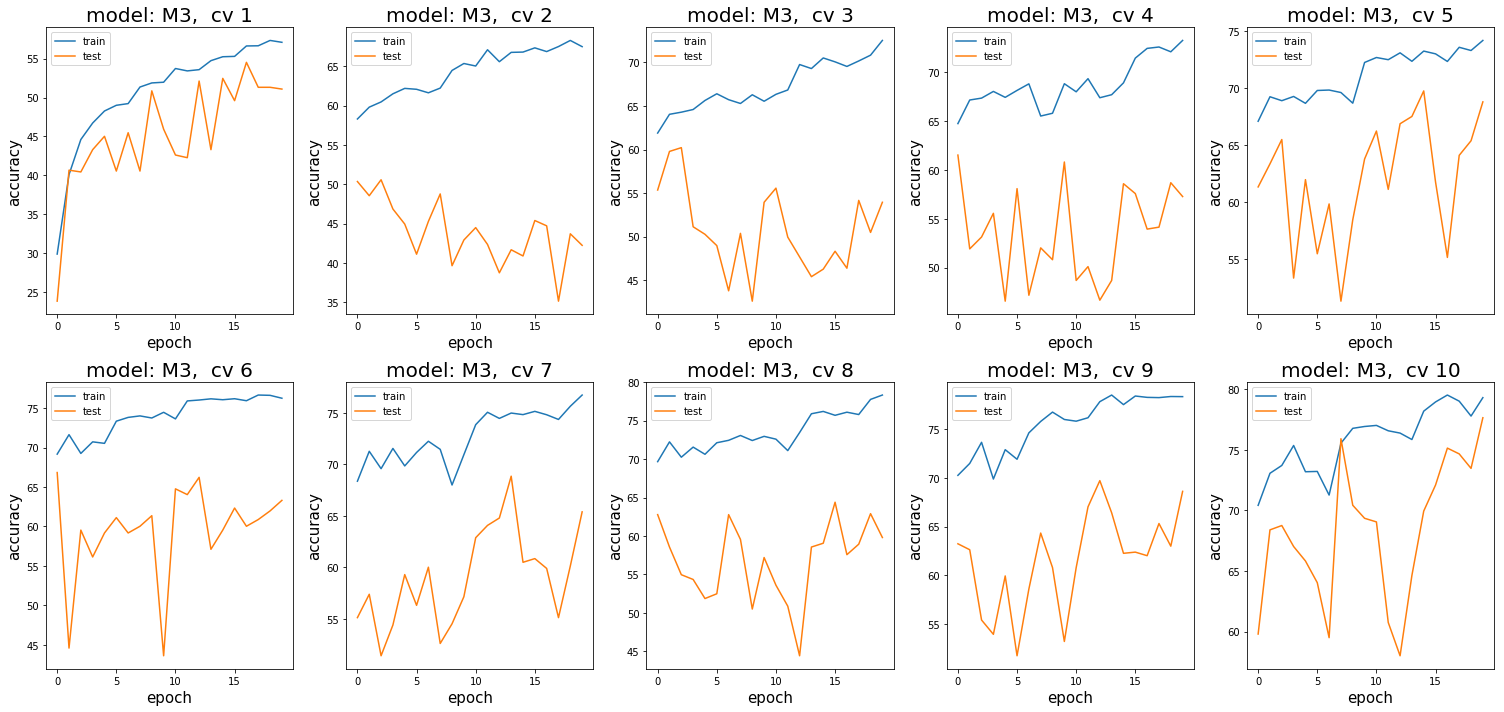

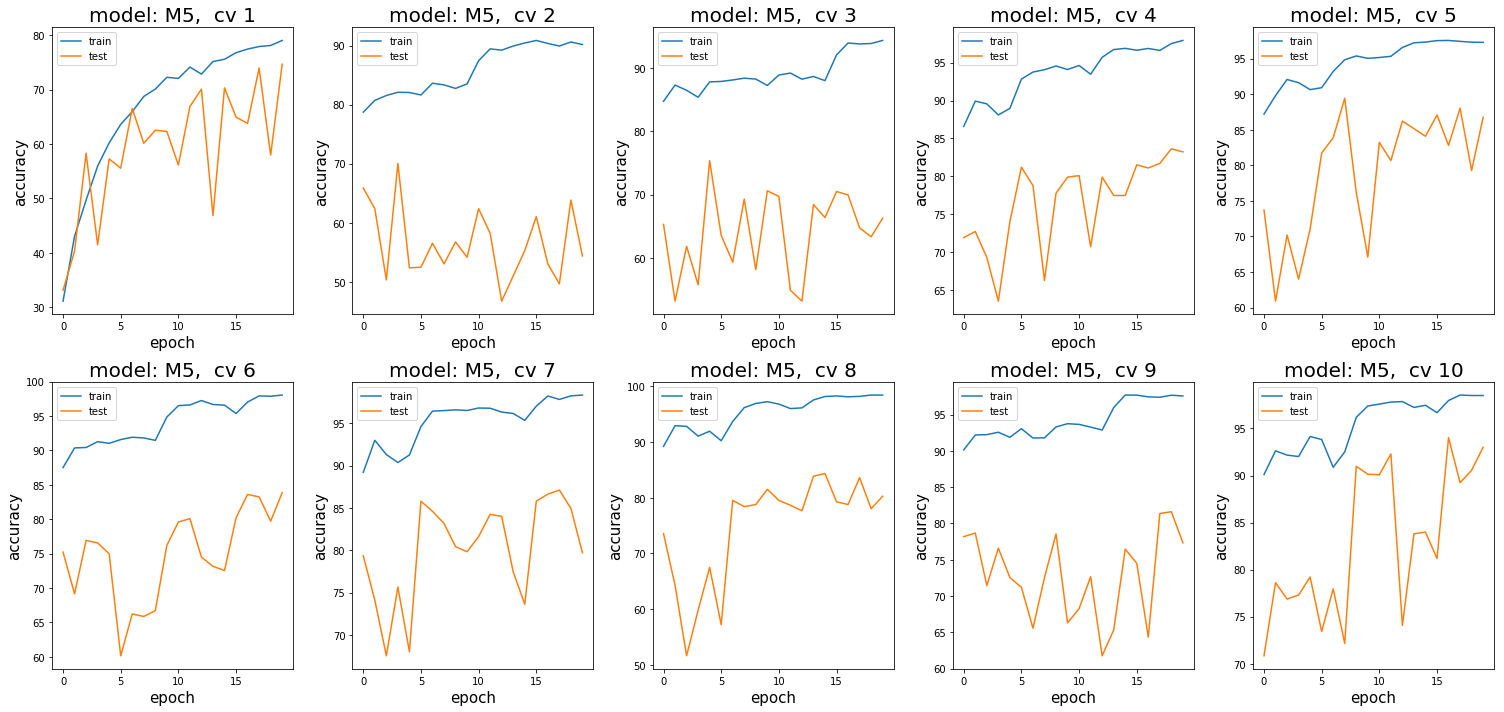

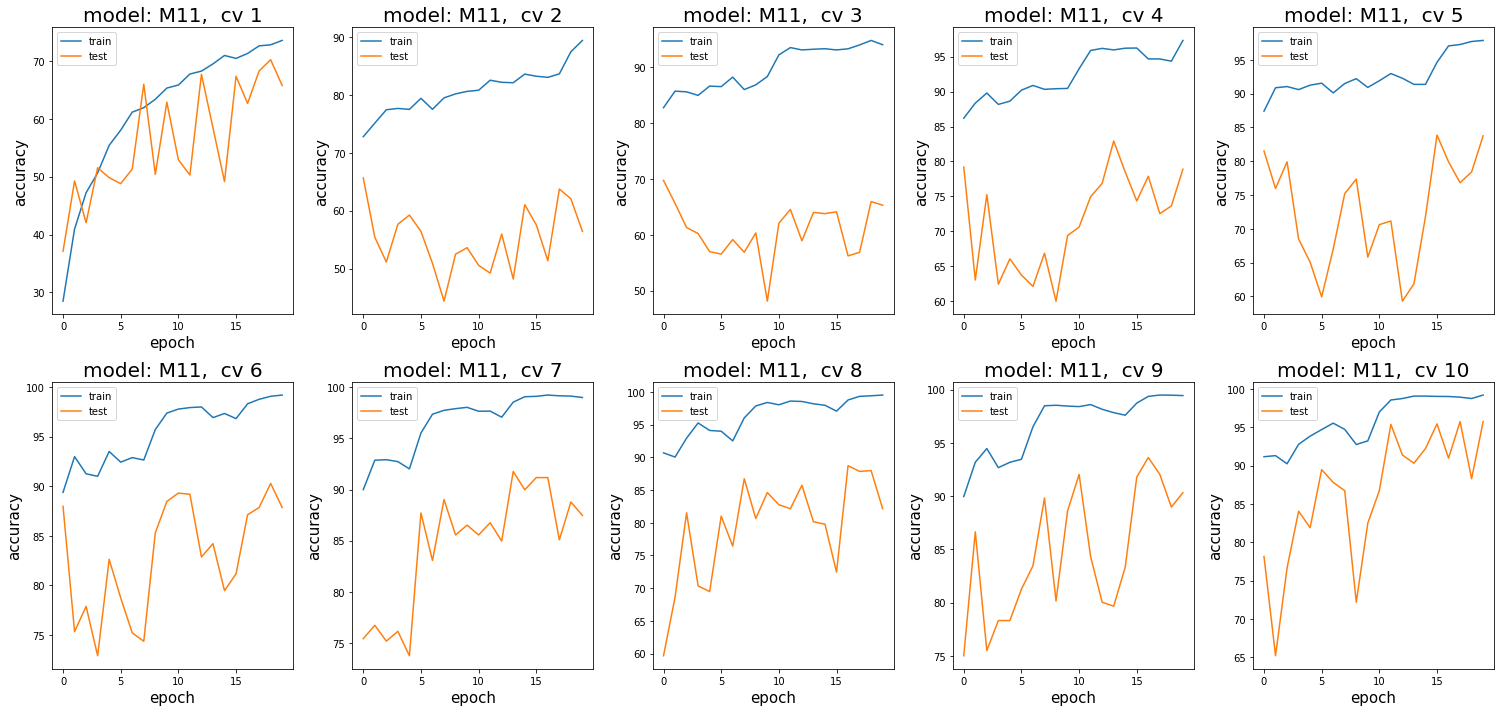

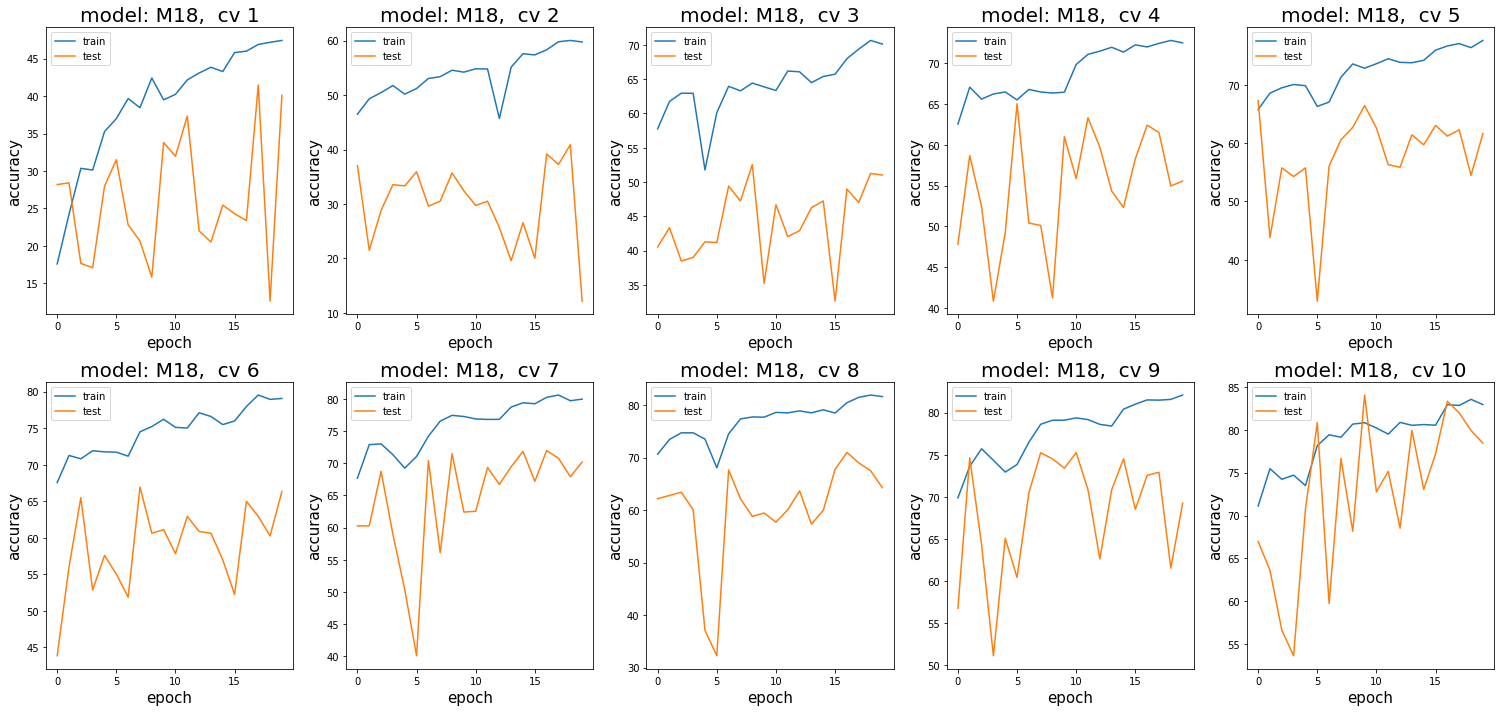

In [124]:
model = ['M3', 'M5', 'M11', 'M18']
#plt.subplots_adjust(top = 2, bottom=1.5, hspace=2, wspace=1)
for m in range(len(model)):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(21,10))
    for i, ax in zip(np.arange(10), axes.flat):
        #plt.figure()
        ax.plot(models_train_acc[m,i,:], label='train')
        ax.plot(models_test_acc[m,i,:], label= 'test')
        ax.set_xlabel('epoch', fontsize=15)
        ax.set_ylabel('accuracy', fontsize=15)
        ax.legend()
        ax.set_title('model: ' + model[m]  + ', ' + ' cv ' + str(i+1), size=20)
        plt.tight_layout()
    plt.savefig('model_' + model[m] + '.png')